<a href="https://colab.research.google.com/github/DenisOgr/kaggle-experiments/blob/master/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Staff for kaggle API
path_to_kaggle_dir='/content/drive/My Drive/kaggle'
! python -m pip install kaggle --upgrade
! mkdir -p ~/.kaggle/
! cp "$path_to_kaggle_dir/kaggle.json" ~/.kaggle/
! ls ~/.kaggle/
!mkdir /content/data

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)
kaggle.json


In [0]:
! kaggle competitions download -c digit-recognizer -p /content/data
!ls /content/data

  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 101MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 84.0MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 212MB/s]
sample_submission.csv  test.csv.zip  train.csv.zip


In [0]:
!unzip -o -d /content/data/ /content/data/test.csv.zip
!unzip -o -d /content/data/ /content/data/train.csv.zip

Archive:  /content/data/test.csv.zip
  inflating: /content/data/test.csv  
Archive:  /content/data/train.csv.zip
  inflating: /content/data/train.csv  


In [0]:
from fastai.vision import *
import numpy as np
import pandas as pd

In [0]:
path = Path('/content/data')
path_to_test = path/'test.csv'
path_to_train = path/'train.csv'
path_to_test;path_to_train

PosixPath('/content/data/train.csv')

In [0]:
class ArrayImageList(ImageList):
    @classmethod
    def from_numpy(cls, numpy_array):
        return cls(items=range(len(numpy_array)),inner_df=numpy_array)
    
    def label_from_array(self, array, label_cls=None, **kwargs):
        return self._label_from_list(array[self.items.astype(np.int)],label_cls=label_cls,**kwargs)
    
    def get(self, i):
        n = self.inner_df[i]
        n = torch.tensor(n).float()
        #n = torch.tensor(n).view(1,28,-1).float()
        return Image(n)

In [0]:
dp_train = pd.read_csv(path_to_train)
dp_test = pd.read_csv(path_to_test)

In [0]:
dp_train.head();
dp_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X = dp_train.iloc[:,1:].copy().values
y =dp_train['label'].to_numpy(); y[0:10]
assert y.shape[0] == X.shape[0]

X_test = dp_test.iloc[:,:].copy().values


In [0]:
#Reshape an existing 2D pandas.dataframe into 3D-numpy.ndarray
X=X.reshape(-1,28,28)
X_test=X_test.reshape(-1,28,28)
# test_img=test.as_matrix()
# test_img=test_img.reshape(-1,28,28)
#Add missing color channels to previously reshaped image
X=np.stack((X,)*3, axis=1).astype('float32')
X_test=np.stack((X_test,)*3, axis=1).astype('float32')
#test_img=np.stack((test_img,)*3, axis=-1).astype('float32')
  
#plt.imshow(img[2])
#plt.title(lbl.iloc[i,0]);

In [0]:
print(X.shape)
print(X_test.shape)

(42000, 3, 28, 28)
(28000, 3, 28, 28)


In [0]:
data = (ArrayImageList.from_numpy(X)
.split_by_rand_pct(valid_pct=0.2)
.label_from_array(y)
.databunch(bs=64)
)

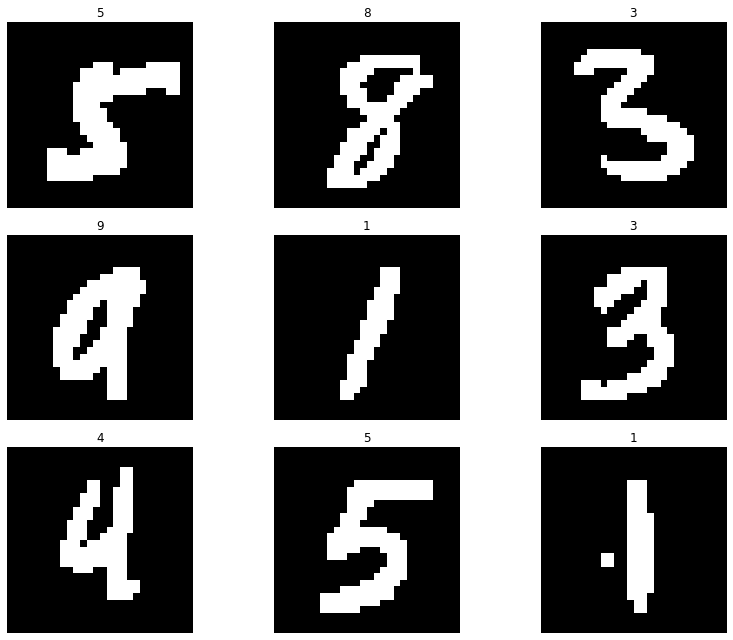

In [0]:
data.show_batch(rows=3, figsize=(12,9), ds_type=DatasetType.Valid)

In [0]:
learn = cnn_learner(data,models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.719567,0.533331,0.159524,00:16
1,0.390738,0.256535,0.082143,00:16
2,0.244695,0.169341,0.055000,00:16
3,0.191042,0.147893,0.048452,00:16


In [0]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.168730,0.141943,0.047024,00:16
1,0.181742,0.140372,0.044405,00:16
2,0.205624,0.128193,0.039048,00:16
3,0.121669,0.099979,0.030119,00:16
4,0.111382,0.093673,0.028452,00:15
5,0.092685,0.079497,0.024048,00:16
6,0.083825,0.073222,0.021905,00:16
7,0.062443,0.074056,0.022381,00:16
8,0.053459,0.071245,0.021429,00:16
9,0.054499,0.071886,0.020952,00:16


In [0]:
learn.save('stage1')

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


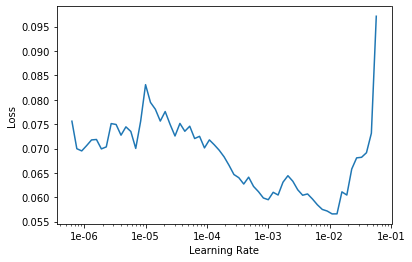

In [0]:
learn.recorder.plot()


In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.085332,0.042146,0.011905,00:21
1,0.059628,0.036902,0.011548,00:21
2,0.020050,0.022716,0.007024,00:21


In [0]:
learn.save('stage2')

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.037098,0.030073,0.009048,00:21
1,0.048524,0.029292,0.009286,00:22
2,0.021732,0.026395,0.008214,00:21
3,0.012964,0.023750,0.005595,00:21
4,0.005263,0.023152,0.005952,00:21


In [0]:
learn.save('stage3')

In [0]:
learn.export()

In [0]:
test_list = ArrayImageList.from_numpy(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


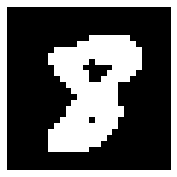

In [0]:
show_image(test_list[310]);

In [0]:
pred=[['ImageId', 'Label']]
for i in range(len(test_list)):
  pred.append([i+1, int(learn.predict(test_list[i])[0])])


In [0]:
np.savetxt("pred.csv", pred, delimiter=",", fmt='%s')


In [0]:
!head pred.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


In [0]:
! kaggle competitions submit -c digit-recognizer -f pred.csv -m"FastAI resnet50 unfreeze"

100% 208k/208k [00:06<00:00, 35.0kB/s]
Successfully submitted to Digit Recognizer